# 作业

本次作业主要涉及强化学习中的dynamic programming和Q-learning

In [ ]:
import numpy as np 
from scipy.special import softmax 
from scipy.stats import bernoulli, norm, uniform
import time 
from scipy.optimize import minimize
from ddm import ddmpdf, pdf # ddm probility density function

from IPython.display import clear_output
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt 
import seaborn as sns 

import sys 
sys.path.append("..") 
from utils.env import frozen_lake
from utils.viz import viz 
viz.get_style()

In [ ]:
# load  data
data = np.loadtxt('exampledata.txt')

###

**Q1.1: 请写出ddm的负对数似然函数`negloglikeli`(negative log-likelihood function)**


In [ ]:
# define a negative log-likelihood objective functions
def negloglikeli(params, data):
    '''
    <params>:(4,) array, drift coefficient, decision boundary, initial bias, non-decision time
    '''
    k = params[0] # drift coefficient
    B = params[1] # decision boundary
    a = params[2] # initial bias (0, 1)
    ndt = params[3] # non-decision time
    
    nTrial = data.shape[0] # how many trials
    pp = np.empty(nTrial)
    for i in range(nTrial): # loop trial
        pp[i] = ddmpdf(k, a, B, ndt, coh=data[i, 0], rt=data[i, 1], correct=data[i, 2])

    pp=0.999*pp + np.finfo(np.float32).eps # to avoid p=0
    return -np.log(pp).sum() # take log, sum，add negative

###

**Q1.2: 利用最大似然估计(maximum likelihood estimation)的方法求解ddm模型参数k,b.a,ndt**

参数k,b.a,ndt的bounds分别为((0, 20), (0, 5), (0, 1), (0, 1))


In [ ]:
res = minimize(fun=negloglikeli, x0=(1.6, 2.3, 0.5, 0.01), args=(data),bounds=((0, 20), (0, 5), (0, 1), (0, 1)))

print('\nfitted drift coefficient is ', res.x[0])
print('fitted decision boundary is ', res.x[1])
print('fitted initial bias is ', res.x[2])
print('fitted nondecision time is ', res.x[3])

###
**Q2: 利用Metropolitan-Hasting的方法求解DDM模型参数.不能借助工具包，必须手写M-H**


In [ ]:
# 定义一个采样分布的概率密度 (input your data, get prob as your output)
def loglikeli(params, data):
    '''
    <params>:(4,) array, drift coefficient, decision boundary, initial bias, non-decision time
    '''
    k = params[0] # drift coefficient
    a = params[1] # decision boundary
    B = params[2] # initial bias (0, 1)
    ndt = params[3] # non-decision time
    
    nTrial = data.shape[0] # how many trials
    prob = np.empty(nTrial)
    
    for i in range(nTrial): # loop trial
        prob[i] = ddmpdf(k, a, B, ndt, coh=data[i, 0], rt=data[i, 1], correct=data[i, 2])
    
    prob=0.999*prob + np.finfo(np.float32).eps # to avoid p=0
    return np.log(prob).sum() # take log, sum


In [ ]:

def metropolis_hastings(data, n_sample=10000, n_burnin=1500):
    sample_chain = []
    current_param = np.array([y_k, y_A, y_B, y_ndt])  # Initialize parameters
    rt_max = data[:, 1].max()  # Maximum response time

    for i in range(n_sample + n_burnin):
        # Propose new parameters from normal distribution
        pro_k = norm(loc=current_param[0]).rvs()
        pro_A = norm(loc=current_param[1]).rvs()
        pro_B = norm(loc=current_param[2]).rvs()
        pro_ndt = norm(loc=current_param[3]).rvs()

        # Ensure a and ndt are within valid ranges
        pro_A = np.exp(pro_A) / (1 + np.exp(pro_A))
        pro_ndt = min([np.exp(pro_ndt) / (1 + np.exp(pro_ndt)), rt_max])

        proposed_param = np.array([pro_k, pro_A, pro_B,  pro_ndt])

        # Calculate log-likelihoods
        loglik_proposed = loglikeli(proposed_param, data)
        loglik_current = loglikeli(current_param, data)

        # acceptance ratio
        acceptance_ratio = min(0, loglik_proposed - loglik_current)

        # Accept or reject 
        if np.log(uniform.rvs()) <= acceptance_ratio:
            current_param = proposed_param

        # accpet only after burn-in period
        if i >= n_burnin:
            sample_chain.append(current_param)

    return np.array(sample_chain)

# Set initial parameter values
y_k = 3
y_B = 3
y_A = 0.5
y_ndt = 0.01

# Call the Metropolis-Hastings algorithm
samples = metropolis_hastings(data)
MH_est = np.mean(samples, axis=0)

In [45]:
MH_est = np.mean(samples, axis=0)
k = [samples[i][0] for i in range(len(samples))]
a = [samples[i][1] for i in range(len(samples))]
b = [samples[i][2] for i in range(len(samples))]
n = [samples[i][3] for i in range(len(samples))]

print(f'fitted drift coefficient is: {np.mean(k)}\n'
      f'fitted decision boundary is: {np.mean(b)}\n'
      f'fitted initial bias is: {np.mean(a)}\n'
      f'fitted nondecision time is: {np.mean(n)}')

fitted drift coefficient is: 4.857210573405569
fitted decision boundary is: 3.4840810438601797
fitted initial bias is: 0.5847440494853477
fitted nondecision time is: 0.1492099465838196


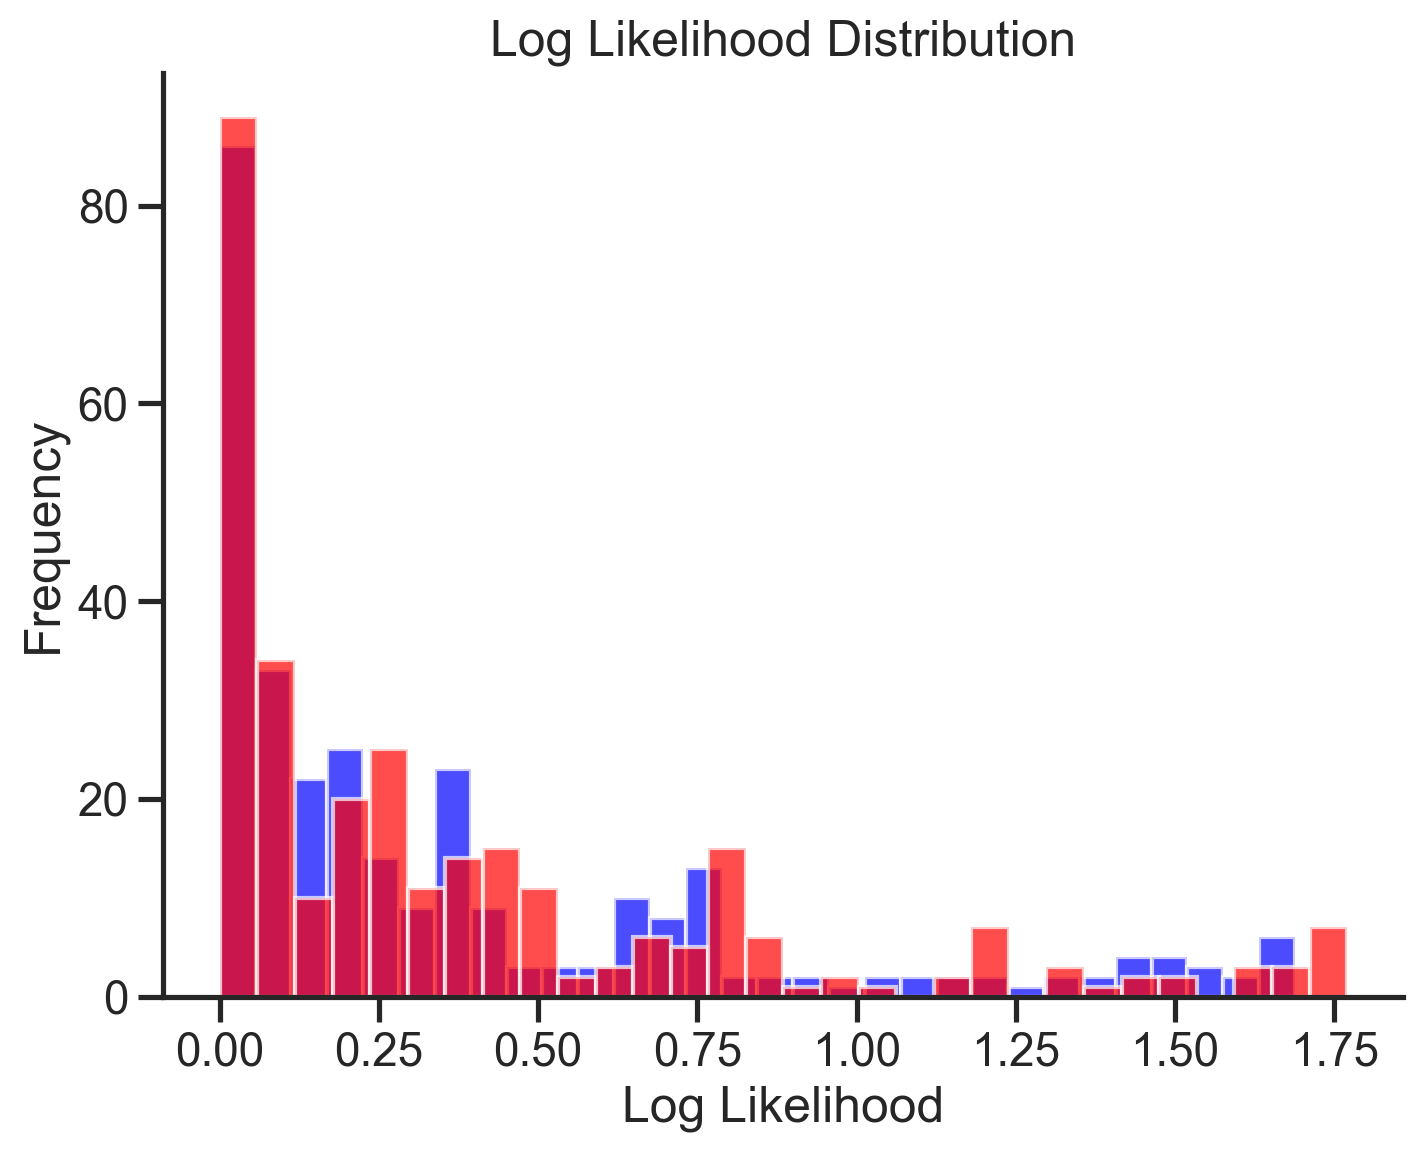

In [46]:
# 计算 log likelihood
MLE_res = res.x
MH_res = MH_est
MLE_ = [ddmpdf(res.x[0], res.x[2], res.x[1], res.x[3], coh=data[i, 0], rt=data[i, 1], correct=data[i, 2]) for i in range(data.shape[0])]
MH_ = [ddmpdf(MH_est[0], MH_est[1], MH_est[2], MH_est[3], coh=data[i, 0], rt=data[i, 1], correct=data[i, 2]) for i in range(data.shape[0])]
# 绘制 log likelihood 的分布
plt.figure(figsize=(8, 6))
plt.hist(MLE_, bins=30, color='blue', alpha=0.7)
plt.hist(MH_, bins=30, color='red', alpha=0.7)
plt.title('Log Likelihood Distribution')
plt.xlabel('Log Likelihood')
plt.ylabel('Frequency')
plt.show()

In [ ]:
seed = 1234
env = frozen_lake(seed=seed)
env.reset()
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
env.render(ax)

###
**Q3.1：现在有nA个action，nS个state。请先随机生成一个policy。每一行代表一个state，每一列代表一个动作.并且令inverse temperature = 5**



In [ ]:
## a random policy
seed = 1234
rng = np.random.RandomState(seed)
pi_rand = softmax(rng.rand(env.nS,env.nA)*5, axis=1)
pi_rand

###
**Q3.2：定义一个评估policy的函数。你需要： 1.在已知当前步的state、action和transition function的情况下，估计下一个可能state的reward和value；2.根据v_new 和 v_old，判断收敛**


In [ ]:

def policy_eval(pi, V, env, theta=1e-4, gamma=.99):
    for s in env.s_termination:
        V[s] = 0 
    while True:
        delta = 0
        for s in env.S:
            if s not in env.s_termination:
                v_old = V[s].copy()
                v_new = 0
                for a in env.A:
                    p = env.p_s_next(s,a)
                    for s_next in env.S:
                        r, done = env.r(s_next)
                        v_new +=  pi[s, a] * p[s_next]*(r+(1-done)*gamma*V[s_next])
                V[s] = v_new
                ## convergence
                delta = np.max([delta, np.abs(v_old-v_new)])             
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
        clear_output(True)
        env.show_v(ax, V)
        time.sleep(1)
        plt.show()   
        if delta < theta:
            break
    return V
        

In [ ]:
V = np.zeros([env.nS])
V = policy_eval(pi_rand, V, env)

###  
**Q3.3：改进policy。**

In [ ]:
## policy_improv
def policy_improv(pi, V, env, theta=1e-4, gamma=.99):
    pi_old = pi.copy()
    for s in env.S:
        # 每一次循环都要重新初始化包含所有action的 q
        q = np.zeros([env.nA])
        for a in env.A:
            p = env.p_s_next(s,a)
            for s_next in env.S:
                r, done = env.r(s_next)
                # q += Σ_a P(s'|s,a)*[r_t+gamma*V(s')] 
                q[a] += p[s_next]*(r+gamma*(1-done)*V[s_next])
        pi[s] = np.eye(env.nA)[np.argmax(q)]
    # loop until stable
    if (np.abs(pi_old - pi) < theta).all():
        stable = True
    else:stable=False
    return pi, stable   
            

###
**Q3.4：完成policy iteration。你需要：1.首先评估policy得到V(value),2.根据得到的V，pi，env来完成迭代**

In [ ]:
def policy_iter(env, seed=1234):
    rng = np.random.RandomState(seed)
    V = rng.randn(env.nS)*0.0001
    # initialize V 除goal为0
    for s in env.s_termination:
        V[s] = 0
    # softmax处理
    pi = softmax(rng.rand(env.nS,env.nA)*5,axis=1)
    
    while True:
        V = policy_eval(pi, V, env)
        pi, stable = policy_improv(pi, V, env)
        # visualize 
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        clear_output(True)
        ax = axs[0]
        env.show_v(ax, V)
        ax = axs[1]
        env.show_pi(ax, pi)
        time.sleep(.1)
        plt.show()   
        
        if stable:break
    return V, pi  
    

In [ ]:
V1, pi1 = policy_iter(env)

###
**Q3.5：完成value iteration。**

In [ ]:
def value_iter(env, seed=1234, theta=1e-4, gamma=.99):
    
    rng = np.random.RandomState(seed)
    # initialize V(s), arbitrarily except V(terminal)=0
    V = np.zeros(env.nS)
    if s in env.s_termination:
        V[s] = 0
    # init policy 
    pi = softmax(rng.randn(env.nS,env.nA)*5, axis=1)    
    # loop until converge
    while True:
        delta = 0
        for s in env.S:
            v_old = V[s].copy()
            v_new = 0
            for a in env.A:
                p = env.p_s_next(s, a)
                for s_next in env.S:
                    r, done = env.r(s_next)
                    v_new += p[s_next]*(r + (1-done)*gamma*V[s_next])
            # calculate V
            V[s] = np.max(v_new)
            # get new policy 

            
            delta = np.max([delta, np.abs(V[s] - v_old)])

        if delta < theta:
            break 
    for s in env.s_termination:
        V[s] = 0
    return V, pi 

### 
**Q4.1：写一段函数，随机生成action**


In [ ]:
def e_greedy(q, rng, env, eps):
    a_max = np.argwhere(q==np.max(q)).flatten()
    policy = np.sum([np.eye(env.nA)[i] for i in a_max], axis=0) / len(a_max)
    if rng.rand() < 1-eps:
        a = rng.choice(env.nA, p=policy)
    else:
        a = rng.choice(env.nA)
    return a 

In [ ]:
def Q_learning(env, alpha=.1, eps=.1, gamma=.99, max_epi=2000, seed=1234, theta=1e-4):
    # rng
    rng = np.random.RandomState(seed)
    # initialize Q
    Q = np.zeros([env.nS, env.nA])
    for _ in range(max_epi):
        s, r, done = env.reset()
        q_old = Q.copy()
        G = 0
        while True:
            # sample At, observe Rt, St+1
            a = e_greedy(Q[s, :], rng, env, eps)
            # a = rng.choice(env.A, p=pi)
            s_next, r, done = env.step(a)
            Q_tar = r + gamma*(1-done)*(Q[s_next, :]).max()
            Q[s, a] += alpha*(Q_tar - Q[s, a])
            s = s_next 
            G += r
            
            if done:
                break 

        if (np.abs(q_old - Q)<theta).all():
            break
    pi = np.eye(env.nA)[np.argmax(Q, axis=1)]
    return Q, pi

### 
**Q4.2：补充sarsa 代码**

In [ ]:
def Sarsa(env, alpha=.2, eps=.1, gamma=.99, max_epi=5000, seed=1234, theta=1e-4):
    # rng
    rng = np.random.RandomState(seed)
    # initialize Q
    Q = np.zeros([env.nS, env.nA])
    for _ in range(max_epi):
        G = 0
        q_old = Q.copy()
        s, _, done = env.reset()
        # sample At, observe Rt, St+1
        a = e_greedy(Q[s, :], rng, env, eps)
        while True:
            s_next, r, done = env.step(a)
            a_next = e_greedy(Q[s_next, :], rng, env, eps)
            Q_tar  = r + (1-done)*gamma*(Q[s_next, a_next])  # 根据Sarsa更新目标Q值
            Q[s,a] += alpha*(Q_tar-Q[s,a])  # 更新Q值
            s = s_next
            a = a_next
            G += r
            if done:
                break 
        delta = np.max(np.abs(q_old - Q))
        if (delta < theta).all():
            break
    pi = np.eye(env.nA)[np.argmax(Q, axis=1)]
    return Q, pi

In [ ]:
## 可视化
Q_sarsa, pi_sarsa = Sarsa(env)
V3 = Q_sarsa.max(1)
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
ax = axs[0]
env.show_v(ax, V3)
ax = axs[1]
env.show_pi(ax, pi_sarsa)